In [6]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None 
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hovm'

input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'salt'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1958, 2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'wbgyr', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2 
which_dpi = 300
do_rescale= None
do_reffig = True
figfac    = [8, 3.5] #ä[7, 3.5]


In [8]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path is not "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None and ref_path != 'None'): 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))    

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [9]:
list_hovm  = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________
    yeari, moni = year, mon
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni = year_ref, mon_ref
        
    #__________________________________________________________________________________________________
    # load fesom2 data
    if not vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
        
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=yeari, mon=moni, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=yeari, mon=moni, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2)
    
    #_________________________________________________________________________________________________
    # create reference hovmoeller data if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_ref = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
        del(data)
        continue
    #_________________________________________________________________________________________________
    data_hovm = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
        
    #_________________________________________________________________________________________________
    # compute hovmoeller anomaly if reference run is given
    if (ref_path != None and ref_path != 'None'):
        list_hovm.append(tpv.do_indexanomaly(data_hovm, data_ref))
    # compute abosulte hovmoeller diagramm    
    else: 
        list_hovm.append(data_hovm)
    del(data, data_hovm)
    
if (ref_path != None and ref_path != 'None'): del(data_ref)    

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


--> histo: cmin, cmax =  34.61883544921875 35.145263671875
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': 34.62, 'cmax': 35.15, 'cref': 35.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f53347d8cd0>, 'clevel': array([34.6  , 34.625, 34.65 , 34.675, 34.7  , 34.725, 34.75 , 34.775,
       34.8  , 34.825, 34.85 , 34.875, 34.9  , 34.925, 34.95 , 34.975,
       35.   , 35.025, 35.05 , 35.075, 35.1  , 35.125, 35.15 ])}


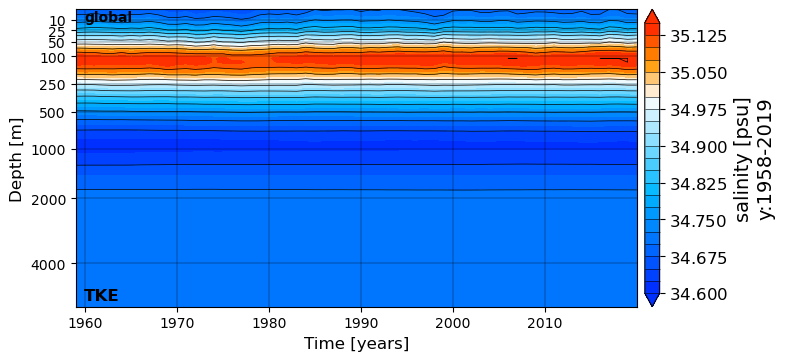

In [10]:
#___PLOT HOVM__________________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = list_hovm[0][0][sname].attrs['str_lsave']
sbox   = list_hovm[0][0][vname].attrs['boxname'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, sbox, slabel) 
ncolumn= np.min([ncolumn,len(list_hovm)])    
nrow   = np.ceil(len(list_hovm)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_index_hovm(list_hovm, box, cinfo=cinfo, figsize=[ncolumn*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncolumn], 
                                    do_rescale=do_rescale, do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale, 
                                    pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], 
                                    do_save = spath, save_dpi=which_dpi )